<a href="https://colab.research.google.com/github/Andribi/A2MF_AP/blob/main/ProvaFacebookPGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PROVA TEST



In [ ]:
# Source: https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_pgan/ 

import torch
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=use_gpu)
# this model outputs 256 x 256 pixel images
# model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
#                        'PGAN', model_name='celebAHQ-256',
#                        pretrained=True, useGPU=use_gpu)



Downloading: "https://github.com/facebookresearch/pytorch_GAN_zoo/archive/hub.zip" to /root/.cache/torch/hub/hub.zip
Downloading: "https://dl.fbaipublicfiles.com/gan_zoo/PGAN/celebaHQ16_december_s7_i96000-9c72988c.pth" to /root/.cache/torch/hub/checkpoints/celebaHQ16_december_s7_i96000-9c72988c.pth


  0%|          | 0.00/264M [00:00<?, ?B/s]

Average network found !


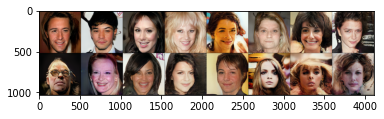

In [ ]:
num_images = 16
# noise, _ = model.buildNoiseData(num_images, inputlabels)

noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)

# let's plot these images using torchvision and matplotlib
import matplotlib.pyplot as plt
import torchvision
grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

## Creazione dataset torch like


In [ ]:
# FAIRFACE CLONE

import os

!git clone https://github.com/Andribi/A2MF_AP.git
%cd /content/A2MF_AP/fairface/

Cloning into 'A2MF_AP'...
remote: Enumerating objects: 195139, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 195139 (delta 8), reused 0 (delta 0), pack-reused 195124
Receiving objects: 100% (195139/195139), 1.80 GiB | 37.07 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Checking out files: 100% (195403/195403), done.
/content/A2MF_AP/fairface


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
use_gpu = True if torch.cuda.is_available() else False


In [ ]:
import pandas as pd

# train labels path
TRAIN_LABELS_PATH = "fairface_label_train.csv"

# validation labels path
VAL_LABELS_PATH = "fairface_label_val.csv"

# seed for shuffle
SEED = 123

# DATA LOAD

fairface_train = pd.read_csv(TRAIN_LABELS_PATH)
fairface_val = pd.read_csv(VAL_LABELS_PATH)
fairface = pd.concat([fairface_train, fairface_val])

# ENCODING

enc_fairface = fairface.drop(columns='service_test')
enc_fairface_train = fairface_train.drop(columns='service_test')
enc_fairface_val = fairface_val.drop(columns='service_test')

def encode_dataset(df):
  """
  Function to encode dataframe using One Hot encoding

  Parameters
  ----------
  df (DataFrame) :  A dataframe with names and attributes of a specific dataset 
                    of images

  Returns
  -------
  df (DataFrame) :  Encoded DataFrame
  """

  attr = df.drop(columns='file')
  names = pd.DataFrame(df['file'])  
  
  enc_df = pd.get_dummies(attr, dtype=float)
  enc_df = enc_df.drop(columns='gender_Female')
  df = pd.concat([names, enc_df], axis=1)
  
  print(df.shape)
  return df

def _sk(x):
  """ 
  Function to transform a path for visual images in a path for sketch images

  Parameters
  ----------
  x (str) :  Path in input (example: 'val/1.jpg' or 'train/1.jpg')

  Returns
  -------
  x (str) :  Transformd path (example: 'val_sk/1.jpg' or 'train_sk/1.jpg')
  """

  if 'train' in x:
    x = x[:5] + '_sk' + x[5:]
  if 'val' in x:
    x = x[:3] + '_sk' + x[3:]
  return x 

# full fairface visible
ff_df = encode_dataset(enc_fairface).replace(0, -1)

# train set visible
train_df = encode_dataset(enc_fairface_train).replace(0, -1)

# val set visible
val_df = encode_dataset(enc_fairface_val).replace(0, -1)

# train set sketch
train_sk_df = train_df.copy()
train_sk_df['file'] = train_sk_df['file'].apply(_sk)

# val set sketch
val_sk_df = val_df.copy()
val_sk_df['file'] = val_sk_df['file'].apply(_sk)

# train set visible + sketch
mixed_train = pd.concat([train_df, train_sk_df], axis=0)
mixed_train = mixed_train.sample(frac=1, random_state=SEED).reset_index(drop=True)
print(mixed_train.shape)

# val set visible + sketch
mixed_val = pd.concat([val_df, val_sk_df], axis=0)
mixed_val = mixed_val.sample(frac=1, random_state=SEED).reset_index(drop=True) 
print(mixed_val.shape)

(97698, 18)
(86744, 18)
(10954, 18)
(173488, 18)
(21908, 18)


In [ ]:
train_df.index = train_df['file']
train_df = train_df.drop(columns='file')
train_dict = train_df.to_dict('index')

In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
import json

train_dict = train_df.to_json(orient='index')
with open('train_attr.json', 'w') as outfile:
    json.dump(json.loads(train_dict), outfile)

In [ ]:
FAIRFACE_PATH = "/content/A2MF_AP/fairface/"
ATTRIB_DICT_PATH = "/content/drive/MyDrive/train_attr.json"

content = {"pathDB": FAIRFACE_PATH, 
           "pathAttribDict": ATTRIB_DICT_PATH}

with open('fairface.json', 'w') as outfile:
    json.dump(content, outfile)

In [ ]:
%cd /content

/content


In [ ]:
# FACEBOOK PGAN CLONE
!git clone https://github.com/facebookresearch/pytorch_GAN_zoo.git

Cloning into 'pytorch_GAN_zoo'...
remote: Enumerating objects: 1523, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 1523 (delta 17), reused 13 (delta 4), pack-reused 1495
Receiving objects: 100% (1523/1523), 2.06 MiB | 18.84 MiB/s, done.
Resolving deltas: 100% (977/977), done.


In [ ]:
%cd /content/pytorch_GAN_zoo/

/content/pytorch_GAN_zoo


In [ ]:
!pip install -r /content/pytorch_GAN_zoo/requirements.txt

     |████████████████████████████████| 676 kB 12.7 MB/s 
     |████████████████████████████████| 411 kB 54.5 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 269 kB 55.5 MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655250 sha256=7672b14db5da0d2e5b6d0ebdb61de833c54732b6b6f8d7727b71499e317eb1ec
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=2b50051f94f98c0971e2d1d5e0caaa72ccd7cb5601d18a9d3e9189d3e2820587
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5710 sha256=65e407dd939bda1a1f60440445c2c033a163d54a15df31b9647dcf99307e07eb
  Stored in directory: /root/.cache/pip/wheels/ac/5c/3a/a80e1c658809

In [ ]:
!python train.py --override

usage: train.py [-h] [--no_vis] [--np_vis] [--restart] [-n NAME] [-d DIR]
                [-c CONFIGPATH] [-s SAVEITER] [-e EVALITER] [-S SCALE_ITER]
                [-v PARTITION_VALUE]
                model_name
train.py: error: the following arguments are required: model_name


In [ ]:
python -m visdom.server

In [ ]:
!python train.py --np_vis PGAN -c /content/drive/MyDrive/fairface.json -n 'prova' -d /content/drive/MyDrive/checkpoints

Running PGAN
size 10
86744 images found
AC-GAN classes : 
{'age_0-2': {'order': 0, 'values': [1.0, -1.0]}, 'age_10-19': {'order': 1, 'values': [1.0, -1.0]}, 'age_20-29': {'order': 2, 'values': [1.0, -1.0]}, 'age_3-9': {'order': 3, 'values': [1.0, -1.0]}, 'age_30-39': {'order': 4, 'values': [1.0, -1.0]}, 'age_40-49': {'order': 5, 'values': [1.0, -1.0]}, 'age_50-59': {'order': 6, 'values': [1.0, -1.0]}, 'age_60-69': {'order': 7, 'values': [1.0, -1.0]}, 'age_more than 70': {'order': 8, 'values': [1.0, -1.0]}, 'gender_Male': {'order': 9, 'values': [1.0, -1.0]}, 'race_Black': {'order': 10, 'values': [1.0, -1.0]}, 'race_East Asian': {'order': 11, 'values': [1.0, -1.0]}, 'race_Indian': {'order': 12, 'values': [1.0, -1.0]}, 'race_Latino_Hispanic': {'order': 13, 'values': [1.0, -1.0]}, 'race_Middle Eastern': {'order': 14, 'values': [1.0, -1.0]}, 'race_Southeast Asian': {'order': 15, 'values': [1.0, -1.0]}, 'race_White': {'order': 16, 'values': [1.0, -1.0]}}

size 10
86744 images found
86744 ima